# Seção 07 - Sistema de Recomendação
### Aluno: Vinícius Trainotti

# Filmes - Sistema de recomendação 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
!wget -nc http://www.razer.net.br/datasets/ml-20m.zip

!unzip -n ml-20m.zip

df = pd.read_csv("ml-20m/ratings.csv")
df.head()


--2023-04-01 15:54:04--  http://www.razer.net.br/datasets/ml-20m.zip
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   127MB/s    in 1.5s    

2023-04-01 15:54:06 (127 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
# userId e movieId não estão no formato certo para usar 
# Embeddings, devem ser categóricos

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes


In [4]:
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values


In [5]:
N = len(set(user_ids))
M = len(set(movie_ids))

# dimensão do embedding (tentar outros)
K = 10


In [6]:
# usuário
u = Input(shape=(1,))
u_emb = Embedding(N, K)(u) # saída : num_samples, 1, K
u_emb = Flatten()(u_emb)   # saída : num_samples, K

# filme
m = Input(shape=(1,))
m_emb = Embedding(M, K)(m)  # saída : num_samples, 1, K
m_emb = Flatten()(m_emb)    # saída : num_samples, K

x = Concatenate()([u_emb, m_emb])

x = Dense(1024, activation="relu")(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)


In [7]:
model.compile(
    loss="mse",
    optimizer=SGD(learning_rate=0.08, momentum=0.9)
)


In [8]:
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

Ntrain = int(0.8 * len(ratings)) # separar os dados 80% x 20%

train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]
test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# centralizar as notas
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating


In [9]:
epochs = 25
r = model.fit(
    x=[train_user, train_movie],
    y=train_ratings,
    epochs=epochs,
    batch_size=1024,
    verbose=2, # não imprime o progresso
    validation_data=([test_user, test_movie], test_ratings)
)


Epoch 1/25
15626/15626 - 360s - loss: 0.7651 - val_loss: 0.7192 - 360s/epoch - 23ms/step
Epoch 2/25
15626/15626 - 349s - loss: 0.6990 - val_loss: 0.6977 - 349s/epoch - 22ms/step
Epoch 3/25
15626/15626 - 348s - loss: 0.6783 - val_loss: 0.6819 - 348s/epoch - 22ms/step
Epoch 4/25
15626/15626 - 337s - loss: 0.6635 - val_loss: 0.6744 - 337s/epoch - 22ms/step
Epoch 5/25
15626/15626 - 339s - loss: 0.6520 - val_loss: 0.6659 - 339s/epoch - 22ms/step
Epoch 6/25
15626/15626 - 347s - loss: 0.6348 - val_loss: 0.6522 - 347s/epoch - 22ms/step
Epoch 7/25
15626/15626 - 351s - loss: 0.6181 - val_loss: 0.6479 - 351s/epoch - 22ms/step
Epoch 8/25
15626/15626 - 346s - loss: 0.6070 - val_loss: 0.6410 - 346s/epoch - 22ms/step
Epoch 9/25
15626/15626 - 353s - loss: 0.5976 - val_loss: 0.6376 - 353s/epoch - 23ms/step
Epoch 10/25
15626/15626 - 351s - loss: 0.5889 - val_loss: 0.6369 - 351s/epoch - 22ms/step
Epoch 11/25
15626/15626 - 353s - loss: 0.5809 - val_loss: 0.6324 - 353s/epoch - 23ms/step
Epoch 12/25
15626/1

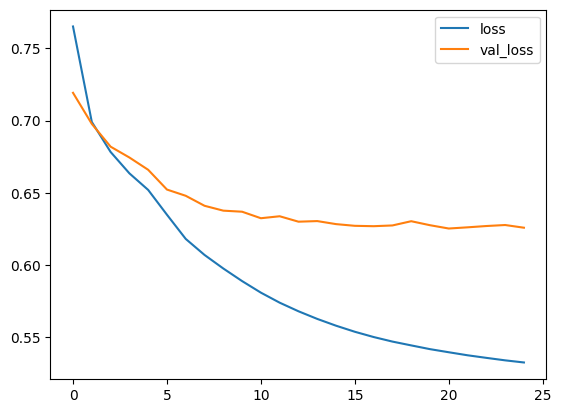

In [10]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()


In [11]:
# Recomendações para o usuário 73023

# Gerar o array com o usuário único
# repete a quantidade de filmes
input_usuario = np.repeat(a=73023, repeats=M) 
film = np.array(list(set(movie_ids)))

preds = model.predict( [input_usuario, film] )

# descentraliza as predições
rat = preds.flatten() + avg_rating

# índice da maior nota
idx = np.argmax(rat)

print("Recomendação: Filme - ", film[idx], " / ", rat[idx] , "*")


836/836 [==============================] - 4s 4ms/step
Recomendação: Filme -  293  /  4.039221 *
